In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# load data

In [0]:
import pandas as pd

path = "/content/drive/My Drive/fire_predict/base_data/"
df_train = pd.read_csv(path + "train_without_elec_gas.csv")
df_val = pd.read_csv(path + "val_without_elec_gas.csv")
df_test = pd.read_csv(path + "test_without_elec_gas.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
binary_y = {'N': 0, 'Y': 1}

df_train['fr_yn'] = df_train['fr_yn'].map(binary_y)
df_val['fr_yn'] = df_val['fr_yn'].map(binary_y)

In [0]:
X_train = df_train.drop(['fr_yn'], 1)
y_train = df_train['fr_yn']
X_val = df_val.drop(['fr_yn'], 1)
y_val = df_val['fr_yn']
test = df_test

In [0]:
df_all = pd.concat([X_train, X_val, test], sort=False)

categorical_cols = df_all.select_dtypes(['object']).columns
for col in categorical_cols:
    df_all[col] = pd.Categorical(df_all[col]).codes

X_train = df_all[:len(df_train)]
X_val = df_all[len(df_train):-len(df_test)]
test = df_all[-len(df_test):]

In [0]:
X_train = X_train.fillna(-1)
X_val = X_val.fillna(-1)
test = test.fillna(-1)

# Import model

In [0]:
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier
from sklearn.metrics import f1_score
import xgboost as xgb
import lightgbm as lgb
import numpy as np

# Define score

In [0]:
def score_predict(model):
    y_pred = model.predict(X_val.values)

    return f1_score(y_val, y_pred)

# Base models

##Gradient Boosting Regression

In [0]:
GBoost = GradientBoostingClassifier(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   random_state =5)
GBoost.fit(X_train.values, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=4,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=15, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=3000,
                           n_iter_no_change=None, presort='auto',
                           random_state=5, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

## XGBoost

In [0]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

In [0]:
model_xgb = xgb.XGBClassifier(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1,
                             objective='binary:logistic')
model_xgb.fit(X_train.values, y_train, eval_metric=f1_eval)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1.7817, missing=None, n_estimators=2200,
              n_jobs=1, nthread=-1, objective='binary:logistic', random_state=7,
              reg_alpha=0.464, reg_lambda=0.8571, scale_pos_weight=1, seed=None,
              silent=1, subsample=0.5213, verbosity=1)

## LightGBM 

In [0]:
model_lgb = lgb.LGBMClassifier(objective='binary',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
model_lgb.fit(X_train.values, y_train, eval_metric=f1_eval)

LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.2319, feature_fraction_seed=9,
               importance_type='split', learning_rate=0.05, max_bin=55,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=6, min_split_gain=0.0,
               min_sum_hessian_in_leaf=11, n_estimators=720, n_jobs=-1,
               num_leaves=5, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

# Base models score

In [0]:
score_predict(GBoost)

0.4477611940298507

In [0]:
score_predict(model_xgb)

0.461139896373057

In [0]:
score_predict(model_lgb)

0.4343434343434343

## Averaged base models class

In [0]:
class AveragingModels():
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.round(np.mean(predictions, axis=1))

## Averaged base models score

In [0]:
averaged_models = AveragingModels(models = (GBoost, model_xgb, model_lgb))
averaged_models.fit(X_train.values, y_train)

In [0]:
averaged_models.predict(X_val.values)

array([1., 0., 0., ..., 0., 0., 1.])

In [0]:
score_predict(averaged_models)

0.451385833699956

# ## Averaged base models class_2

In [0]:
from sklearn.model_selection import GridSearchCV


def print_best_params(model, params):
    grid_model = GridSearchCV(
        model, 
        param_grid = params,
        cv=5,
        scoring='neg_mean_squared_error')

    grid_model.fit(X_train, y_train)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print(
        '{0} 5 CV 시 최적 평균 RMSE 값 {1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

In [0]:
xgb_params ={
    'learning_rate': [0.05],
    'max_depth': [5],
    'subsample': [0.9],
    'colsample_bytree': [0.5],
    'silent': [True],
    'gpu_id':[0] ,         
    'tree_method':['gpu_hist'],
    'predictor':['gpu_predictor'],
    'n_estimators':[1000],
    'refit' : [True]
}

xgb_model = xgb.XGBClassifier()
xgb_estimator = print_best_params(xgb_model, xgb_params)

XGBClassifier 5 CV 시 최적 평균 RMSE 값 0.3918, 최적 alpha:{'colsample_bytree': 0.5, 'gpu_id': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000, 'predictor': 'gpu_predictor', 'refit': True, 'silent': True, 'subsample': 0.9, 'tree_method': 'gpu_hist'}


In [0]:
lgb_params = {
    'objective':['binary'],
    'num_leave' : [1],
    'learning_rate' : [0.05],
    'n_estimators':[1000],
    'max_bin' : [80],
    'gpu_id':[0] ,         
    'tree_method':['gpu_hist'],
    'predictor':['gpu_predictor'],
    'refit':[True]
}

lgb_model = lgb.LGBMClassifier()
lgb_estimator = print_best_params(lgb_model, lgb_params)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:741: UserWarning: predictor keyword has been found in `params` and will be ignored.
Please use predictor argument of the Dataset constructor to pass this parameter.
  .format(key))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:741: UserWarning: predictor keyword has been found in `params` and will be ignored.
Please use predictor argument of the Dataset constructor to pass this parameter.
  .format(key))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:741: UserWarning: predictor keyword has been found in `params` and will be ignored.
Please use predictor argument of the Dataset constructor to pass this parameter.
  .format(key))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:741: UserWarning: predictor keyword has been found in `params` and will be ignored.
Please use predictor argument of the Dataset constructor to pass this parameter.
  .format(key))
/usr/local/lib/python3.6/dist-packages/lightgbm/

LGBMClassifier 5 CV 시 최적 평균 RMSE 값 0.3923, 최적 alpha:{'gpu_id': 0, 'learning_rate': 0.05, 'max_bin': 80, 'n_estimators': 1000, 'num_leave': 1, 'objective': 'regression', 'predictor': 'gpu_predictor', 'refit': True, 'tree_method': 'gpu_hist'}


In [0]:
xgb_preds = xgb_estimator.predict(X_val)
lgb_preds = lgb_estimator.predict(X_val)
preds = 0.5* xgb_preds + 0.5*lgb_preds

In [0]:
f1_score(y_val,np.ceil(preds))

0.4862518089725037

In [0]:
f1_score(y_val,np.floor(preds))

0.46873633581110624

In [0]:
from sklearn.neural_network import MLPClassifier


model = MLPClassifier()
model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [0]:
model.predict(X_val)

array([1, 1, 0, ..., 1, 0, 1])

In [0]:
score_predict(model)

0.40238040741588466

# deep learning

Rules of Thumb

We have a variety of neural networks. Among them, a multilayer perceptron is the “hello world” of Deep Learning. And, therefore, a good place to start when you are learning about or developing a new model in Deep Learning.
Following are the thumb-rules for building an MLP. However, most of them are applicable on other Deep Learning models.
Number of Layers: Start with two hidden layers (this does not include the last layer).

Number of nodes (size) of intermediate layers: a number from the geometric progression of 2, e.g., 4, 8, 16, 32, … . The first layer should be around half of the number of input data features. The next layer size as half of the previous.

Number of nodes (size) of output layer for Classification: If binary classification then the size is one. For a multi-class classifier, the size is the number of classes.

Size of output layer for regression: If single response then the size one. For multi-response regression, the size is the number of responses.

Activation for intermediate layers: Use relu activation.

Activation for output layer: Use sigmoid for binary classification, softmax for multi-class classifier, and linear for regression. For Autoencoders, the last layer should be linear if the input data is continuous, otherwise, sigmoid or softmax for binary or multi-level categorical input.

Dropout layers: Add Dropout after every layer, except the Input layer (if defining the Input layer separately). Set Dropout rate to 0.5. Dropout rate > 0.5 is counter-productive. If you believe a rate of 0.5 is regularizing too many nodes, then increase the size of the layer instead of reducing the Dropout rate to less than 0.5. I prefer to not set any Dropout on the Input layer. But if you feel compelled to do that, set the Dropout rate < 0.2.

Data preprocessing: I am assuming your predictors X is numeric and you have already converted any categorical columns into one-hot-encoding. Before using the data for model training, perform data scaling. UseMinMaxScaler from sklearn.preprocessing. If this does not work well, do StandardScaler present in the same library. The scaling is needed for y in regression.

Split data to train, valid, test: Use train_test_split from sklearn.model_selection. See example below.

Class weights: If you have unbalanced data, then set class weights to balance the loss in your model.fit . For a binary classifier, the weights should be: {0: number of 1s / data size, 1: number of 0s / data size}. For extremely unbalanced data (rare events), class weight may not work. Be cautious adding it.
Optimizer: Use adam with its default learning rate.

Loss in classification: For binary classification use binary_crossentropy. For multiclass, use categorical_crossentropy if the labels are one-hot-encoded, otherwise use sparse_categorical_crossentropy if the labels are integers.
Loss in regression: Use mse.

Metrics for Classification: Use accuracy that shows the percent of correct classifications. For unbalanced data, also include tf.keras.metrics.Recall() and tf.keras.metrics.FalsePositives().

Metric for Regression: Use tf.keras.metrics.RootMeanSquaredError().

Epochs: Start with 20 to see if the model training shows decreasing loss and any improvement in accuracy. If there is no minimal success with 20 epochs, move on. If you get some minimal success, make epoch as 100.

Batch size: Choose the batch size from the geometric progression of 2. For unbalanced datasets have larger value, like 128, otherwise start with 16.

# 기본

In [0]:
import tensorflow as tf
import keras.backend.tensorflow_backend as K


def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [0]:
from tensorflow.keras import layers
import tensorflow as tf
from keras.callbacks import EarlyStopping


model_2= tf.keras.Sequential()
model_2.add(layers.Dense(64, activation="relu"))
model_2.add(layers.Dense(32, activation="relu"))
model_2.add(layers.Dense(1, activation="sigmoid"))

early_stopping = EarlyStopping(monitor='val_loss', patience = 10, mode='min')

model_2.compile(optimizer=tf.keras.optimizers.Adadelta(),
              loss=f1_loss,
              metrics=["accuracy", f1],
              callbacks=[early_stopping])

In [0]:
history = model_2.fit(X_train.values, y_train.values, 100, 50, validation_data=(X_val.values, y_val.values))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 59199 samples, validate on 6898 samples
Epoch 1/50
59199/59199 [==============================] - 3s 55us/sample - loss: 0.8560 - acc: 0.6201 - f1: 0.1440 - val_loss: 0.8633 - val_acc: 0.5906 - val_f1: 0.1367
Epoch 2/50
59199/59199 [==============================] - 2s 39us/sample - loss: 0.8568 - acc: 0.6258 - f1: 0.1431 - val_loss: 0.8645 - val_acc: 0.6000 - val_f1: 0.1357
Epoch 3/50
59199/59199 [==============================] - 2s 38us/sample - loss: 0.8588 - acc: 0.6320 - f1: 0.1412 - val_loss: 0.8688 - val_acc: 0.6037 - val_f1: 0.1312
Epoch 4/50
59199/59199 [==============================] - 2s 39us/sample - loss: 0.8595 - acc: 0.6363 - f1: 0.1404 - val_loss: 0.8695 - val_acc: 0.6112 - val_f1: 0.1305
Epoch 5/50
59199/59199 [==============================] - 2s 38us/sample - loss: 0.8616 - acc: 0.642

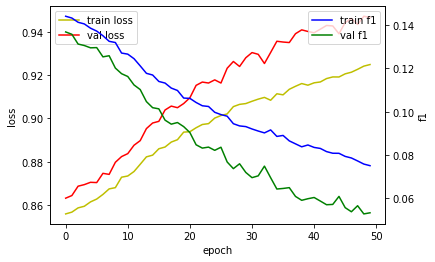

In [0]:
from matplotlib import pyplot as plt


fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history["f1"], 'b', label='train f1')
acc_ax.plot(history.history["val_f1"], 'g', label='val f1')
acc_ax.set_ylabel('f1')
acc_ax.legend(loc='upper right')



plt.show()

# 개선

In [0]:
from matplotlib import pyplot as plt


def plot_loss(history):

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    acc_ax.plot(history.history["f1"], 'b', label='train f1')
    acc_ax.plot(history.history["val_f1"], 'g', label='val f1')
    acc_ax.set_ylabel('f1')
    acc_ax.legend(loc='upper right')



    plt.show()

In [0]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
import tensorflow as tf
from keras.callbacks import EarlyStopping


model_2= tf.keras.Sequential()
model_2.add(layers.Dense(32, activation="relu"))
model_2.add(Dropout(0.5))
model_2.add(layers.Dense(16, activation="relu"))
model_2.add(Dropout(0.5))
model_2.add(layers.Dense(1, activation="sigmoid"))

early_stopping = EarlyStopping(monitor='val_loss', patience = 10, mode='min')

model_2.compile(optimizer=tf.keras.optimizers.Adadelta(),
              loss=f1_loss,
              metrics=["accuracy", f1],
              callbacks=[early_stopping])

In [0]:
class_weight_ = {0: sum(y_train == 1)/len(y_train), 1: sum(y_train == 0)/len(y_train)}

In [0]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [0]:
class_weight_

{0: 0.12934340107096404, 1: 0.870656598929036}

In [0]:
class_weights

array([0.57427923, 3.86567846])

In [0]:
history = model_2.fit(X_train.values, y_train.values, 128, 50,
                      validation_data=(X_val.values, y_val.values),
                      class_weight=class_weights)

Train on 59199 samples, validate on 6898 samples
Epoch 1/50
59199/59199 [==============================] - 2s 38us/sample - loss: 0.8234 - acc: 0.6824 - f1: 0.1769 - val_loss: 0.9763 - val_acc: 0.8140 - val_f1: 0.0237
Epoch 2/50
59199/59199 [==============================] - 2s 33us/sample - loss: 0.8318 - acc: 0.6776 - f1: 0.1680 - val_loss: 0.9739 - val_acc: 0.8140 - val_f1: 0.0261
Epoch 3/50
59199/59199 [==============================] - 2s 34us/sample - loss: 0.8281 - acc: 0.6808 - f1: 0.1717 - val_loss: 0.9756 - val_acc: 0.8140 - val_f1: 0.0244
Epoch 4/50
59199/59199 [==============================] - 2s 33us/sample - loss: 0.8327 - acc: 0.6808 - f1: 0.1668 - val_loss: 0.9764 - val_acc: 0.8140 - val_f1: 0.0236
Epoch 5/50
59199/59199 [==============================] - 2s 33us/sample - loss: 0.8320 - acc: 0.6768 - f1: 0.1683 - val_loss: 0.9760 - val_acc: 0.8140 - val_f1: 0.0240
Epoch 6/50
59199/59199 [==============================] - 2s 36us/sample - loss: 0.8313 - acc: 0.6777 - f1

In [0]:
from imblearn.over_sampling import SMOTE
from collections import Counter


smote = SMOTE(random_state=212)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train_resampled))

Resampled dataset shape Counter({0: 51542, 1: 51542})


In [0]:
history = model_2.fit(X_train_resampled, y_train_resampled, 128, 50,
                      validation_data=(X_val.values, y_val.values),
                      class_weight=class_weights)

Train on 103084 samples, validate on 6898 samples
Epoch 1/50
103084/103084 [==============================] - 3s 32us/sample - loss: 0.6587 - acc: 0.5012 - f1: 0.3428 - val_loss: 0.9771 - val_acc: 0.8140 - val_f1: 0.0228
Epoch 2/50
103084/103084 [==============================] - 3s 32us/sample - loss: 0.6614 - acc: 0.5004 - f1: 0.3399 - val_loss: 0.9783 - val_acc: 0.8140 - val_f1: 0.0216
Epoch 3/50
103084/103084 [==============================] - 3s 31us/sample - loss: 0.6580 - acc: 0.4999 - f1: 0.3433 - val_loss: 0.9787 - val_acc: 0.8140 - val_f1: 0.0213
Epoch 4/50
103084/103084 [==============================] - 3s 31us/sample - loss: 0.6605 - acc: 0.5009 - f1: 0.3413 - val_loss: 0.9781 - val_acc: 0.8140 - val_f1: 0.0219
Epoch 5/50
103084/103084 [==============================] - 3s 32us/sample - loss: 0.6639 - acc: 0.4978 - f1: 0.3374 - val_loss: 0.9779 - val_acc: 0.8140 - val_f1: 0.0220
Epoch 6/50
103084/103084 [==============================] - 3s 32us/sample - loss: 0.6598 - acc

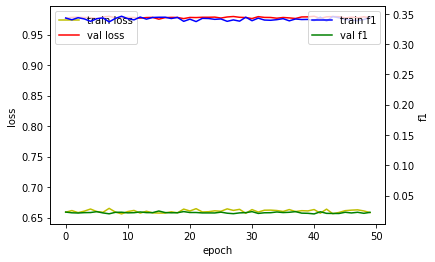

In [0]:
plot_loss(history)

In [0]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, AlphaDropout
import tensorflow as tf
from keras.callbacks import EarlyStopping


model_2= tf.keras.Sequential()
model_2.add(layers.Dense(32, kernel_initializer='lecun_normal',
                         activation='selu'))
model_2.add(AlphaDropout(0.1))
model_2.add(layers.Dense(16, kernel_initializer='lecun_normal',
                         activation='selu'))
model_2.add(AlphaDropout(0.1))
model_2.add(layers.Dense(1, activation="sigmoid"))

early_stopping = EarlyStopping(monitor='val_loss', patience = 10, mode='min')

model_2.compile(optimizer=tf.keras.optimizers.Adadelta(),
              loss=f1_loss,
              metrics=["accuracy", f1],
              callbacks=[early_stopping])

In [0]:
history = model_2.fit(X_train.values, y_train, 128, 50,
                      validation_data=(X_val.values, y_val.values),
                      class_weight=class_weights)

Train on 59199 samples, validate on 6898 samples
Epoch 1/50
59199/59199 [==============================] - 2s 39us/sample - loss: 0.7742 - acc: 0.1448 - f1: 0.2258 - val_loss: 0.6908 - val_acc: 0.1851 - val_f1: 0.3091
Epoch 2/50
59199/59199 [==============================] - 2s 36us/sample - loss: 0.7736 - acc: 0.1446 - f1: 0.2264 - val_loss: 0.6904 - val_acc: 0.1851 - val_f1: 0.3095
Epoch 3/50
59199/59199 [==============================] - 2s 36us/sample - loss: 0.7746 - acc: 0.1445 - f1: 0.2254 - val_loss: 0.6907 - val_acc: 0.1851 - val_f1: 0.3092
Epoch 4/50
59199/59199 [==============================] - 2s 37us/sample - loss: 0.7736 - acc: 0.1439 - f1: 0.2264 - val_loss: 0.6909 - val_acc: 0.1851 - val_f1: 0.3091
Epoch 5/50
59199/59199 [==============================] - 2s 35us/sample - loss: 0.7746 - acc: 0.1435 - f1: 0.2254 - val_loss: 0.6909 - val_acc: 0.1851 - val_f1: 0.3092
Epoch 6/50
59199/59199 [==============================] - 2s 36us/sample - loss: 0.7742 - acc: 0.1444 - f1

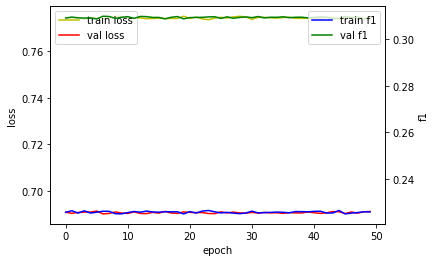

In [0]:
plot_loss(history)

In [0]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score
import xgboost as xgb
import lightgbm as lgb
import numpy as np


def score_predict(model, X_val):
    y_pred = model.predict(X_val)

    return f1_score(y_val, y_pred)

def fit_g_boost(X_train, y_train):

    GBoost = GradientBoostingClassifier(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   random_state =5)
    GBoost.fit(X_train, y_train)

    return GBoost

def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

def fit_xgb(X_train, y_train):

    model_xgb = xgb.XGBClassifier(colsample_bytree=0.4603, gamma=0.0468, 
                                learning_rate=0.05, max_depth=3, 
                                min_child_weight=1.7817, n_estimators=2200,
                                reg_alpha=0.4640, reg_lambda=0.8571,
                                subsample=0.5213, silent=1,
                                random_state =7, nthread = -1,
                                objective='binary:logistic')
    model_xgb.fit(X_train, y_train, eval_metric=f1_eval)
    return model_xgb

def fit_lgb(X_train, y_train):

    model_lgb = lgb.LGBMClassifier(objective='binary',num_leaves=5,
                            learning_rate=0.05, n_estimators=720,
                            max_bin = 55, bagging_fraction = 0.8,
                            bagging_freq = 5, feature_fraction = 0.2319,
                            feature_fraction_seed=9, bagging_seed=9,
                            min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
    model_lgb.fit(X_train, y_train, eval_metric=f1_eval)
    return model_lgb


def average_predict(models, X_val):
    predictions = np.column_stack([
        model.predict(X_val) for model in models
    ])
    return np.round(np.mean(predictions, axis=1))

def total_predict(X_train, y_train, X_val):

    model_g_boost = fit_g_boost(X_train, y_train)
    model_xgb = fit_xgb(X_train, y_train)
    model_lgb = fit_lgb(X_train, y_train)

    f1_g_boost = score_predict(model_g_boost, X_val)
    f1_xgb = score_predict(model_xgb, X_val)
    f1_lgb = score_predict(model_lgb, X_val)
    predict_average = average_predict((model_g_boost, model_xgb, model_lgb),
                                    X_val)
    f1_score_average = f1_score(y_val, predict_average)
    return [[f1_g_boost, f1_xgb, f1_lgb], f1_score_average]

In [0]:
total_predict(X_train.values, y_train, X_val.values)

[[0.4477611940298507, 0.461139896373057, 0.4343434343434343],
 0.451385833699956]